# Geopandas

In [1]:
import pandas as pd
import geopandas
import shapely.wkt
import rtree
import matplotlib.pyplot as plt
%matplotlib inline

## Tipos de datos geográficos

La información geográfica generalmente se agrupa en dos grandes categorías:

- Datos ráster
- Datos vectoriales

**Ráster**: Los datos ráster son aquellos donde la información se encuentra codificada sobre una grilla o red, donde cada celda (o píxel) presenta un valor numérico. Los datos ráster son usados comúnmente en imágenes satelitales, en este caso cada píxel representa un espacio definido por la granularidad o calidad de la imagen tomada, por ejemplo, un píxel puede representar una superficie de 30 metros por 30 metros.

Sin embargo, en esta clase nos vamos a concentrar en los datos **vectoriales**. En los datos vectoriales contamos con los siguientes tipos de objetos básicos: puntos, líneas, polígonos; así también tenemos multipunto, multilínea y multipolígono. La información se estructura a partir de las coordenadas de los vértices de cada uno de esos objetos.

## GeoPandas
GeoPandas es la librería de Python por excelencia para el procesamiento de datos vectoriales. Provee fácil acceso a una serie de funcionalidades empleando diversas librerías:

- Manipulación de datos con Pandas.
- Lectura de archivos espaciales a través de Fiona.
- Objetos vectoriales y operaciones vectoriales con Shapely.
- Visualización de mapas con Descartes y Matplotlib.

### Importando datos

La datos vectoriales comúnmente se presenta en archivos como el formato shapefile (.shp) de ESRI, archivos GeoJSON, bases de PostGIS (es una extensión del motor de bases de datos PostgreSQL), etc.
Con la librería **GeoPandas** se pueden leer muchos de estos archivos, interfaceando con la librería GDAL/OGR, usando la función geopandas.read_file.
Además, también es posible leer información geográfica desde archivos planos (.csv) donde tenemos las coordenadas de puntos que referencian algún objeto. Por último, también existen casos en los que la información está guardada en formato WKT (Well-Known Text).

En esta notebook vamos a ver distintas formas de importar información geográfica de archivos vectoriales.

In [2]:
# https://data.buenosaires.gob.ar/dataset/barrios
barrios = pd.read_csv("https://datasets-humai.s3.amazonaws.com/datasets/barrios.csv", encoding='latin1')

In [3]:
barrios.head()

,WKT,BARRIO,COMUNA,PERIMETRO,AREA
0,"POLYGON ((-58.4528200492791 -34.5959886570639,...",CHACARITA,15.0,7725.695228,3.118101e+06
1,"POLYGON ((-58.4655768128541 -34.5965577078058,...",PATERNAL,15.0,7087.513295,2.229829e+06
2,"POLYGON ((-58.4237529813037 -34.5978273383243,...",VILLA CRESPO,15.0,8132.699348,3.613584e+06
3,"POLYGON ((-58.4946097568899 -34.6148652395239,...",VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06
4,"POLYGON ((-58.4128700313089 -34.6141162515854,...",ALMAGRO,5.0,8537.901368,4.050752e+06


In [4]:
# En este caso la información está en WKT
barrios["WKT"].iloc[0]

'POLYGON ((-58.4528200492791 -34.5959886570639,-58.453655193137 -34.5965557163041,-58.4537674321647 -34.5966342484152,-58.4538163134148 -34.5966684788922,-58.4547947928051 -34.5973527273644,-58.4554840815948 -34.5978347610252,-58.4559204833296 -34.5976953435829,-58.4560093721285 -34.5976669530232,-58.4560576047802 -34.5976515472868,-58.4562363723257 -34.5975900748435,-58.4564940053845 -34.597501563774,-58.4570733158433 -34.5973024999733,-58.4576142986162 -34.5971165306991,-58.4578298572666 -34.5970394940224,-58.4579314199407 -34.5970031094655,-58.4579383597538 -34.5970006235554,-58.457939151188 -34.5970004324803,-58.4580314840712 -34.5969781271249,-58.4582467474022 -34.5969261254882,-58.4592081863103 -34.5966936826245,-58.4592753814056 -34.5966774864904,-58.4607717313584 -34.5965908256843,-58.461008489241 -34.5965771669178,-58.461500184562 -34.5965469590603,-58.4615048306102 -34.5965466787569,-58.4623220712384 -34.5965110490604,-58.4624802220071 -34.5965042183086,-58.4625206541306 -34.

### GeoDataFrames: métodos y atributos

Los GeoDataFrame son objetos que tienen los mismos atributos que un Pandas DataFrame, con lo cual se puede manipular de datos a la que estamos acostumbrados. Como, por ejemplo, el método .plot(), acceso por .loc, .iloc, etc.
Además, los GeoDataFrames tienen un atributo *geometry* que indica la columna que contiene la información geográfica.

In [5]:
def from_wkt(df, wkt_column):
    
    df["coordinates"]= df[wkt_column].apply(shapely.wkt.loads) # empleamos una función de shapely para leer WKT
        
    gdf = geopandas.GeoDataFrame(barrios, geometry='coordinates') # seteamos la columna de geometría
    
    return gdf


In [6]:
barrios = from_wkt(barrios, "WKT")

In [7]:
barrios.query("BARRIO == 'CABALLITO'") # podemos usar query

,WKT,BARRIO,COMUNA,PERIMETRO,AREA,coordinates
5,"POLYGON ((-58.4306058283309 -34.6070470885963,...",CABALLITO,6.0,10990.964471,6.851029e+06,"POLYGON ((-58.43061 -34.60705, -58.43056 -34.6..."


In [8]:
barrios[barrios['BARRIO']=='CABALLITO'] # podemos hacer boolean indexing

,WKT,BARRIO,COMUNA,PERIMETRO,AREA,coordinates
5,"POLYGON ((-58.4306058283309 -34.6070470885963,...",CABALLITO,6.0,10990.964471,6.851029e+06,"POLYGON ((-58.43061 -34.60705, -58.43056 -34.6..."


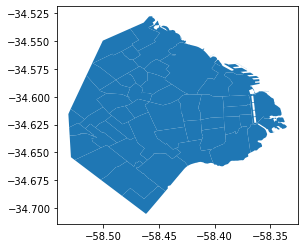

In [9]:
barrios.plot(); # BOOM: con uds. CABA!

A diferencia del Pandas DataFrame, tiene un atributo que mantiene la información de la geometría.

In [10]:
barrios.geometry.head() 

0    POLYGON ((-58.45282 -34.59599, -58.45366 -34.5...
1    POLYGON ((-58.46558 -34.59656, -58.46562 -34.5...
2    POLYGON ((-58.42375 -34.59783, -58.42495 -34.5...
3    POLYGON ((-58.49461 -34.61487, -58.49479 -34.6...
4    POLYGON ((-58.41287 -34.61412, -58.41282 -34.6...
Name: coordinates, dtype: geometry

Noten que cada barrio es un polígono

In [11]:
barrios.crs = "EPSG:4326" # seteamos el 'coordinate reference system', EPSG 4326 equivale a WGS 84

### Objetos geométricos

La librería shapely nos provee acceso a los objetos geométricos. Con ella podemos generar los objetos Point, Polygon y Line. Veamos un ejemplo.

Además, podemos especificar la proyección pasando el parámetro crs. Para ver cómo transformar una proyección se puede ir a: http://geopandas.readthedocs.io/en/latest/projections.html

In [12]:
from shapely.geometry import Point

p = Point(-58.396295, -34.591789) # Armo un punto a partir de dos coordenadas geográficas

df = pd.DataFrame(data = {'id': [1]}) # Armo un DataFrame

gdf = geopandas.GeoDataFrame(df, crs="EPSG:4326", geometry=[p])

In [13]:
gdf # este es un GeoDataFrame con un solo punto

,id,geometry
0,1,POINT (-58.39630 -34.59179)


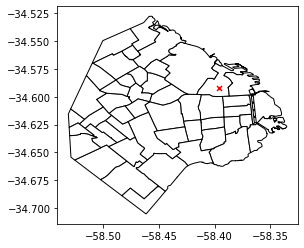

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_aspect('equal')
barrios.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, marker='x', color='red', markersize=25)
plt.show();

Si quisiéramos podemos cambiar la proyección empleando el método .to_crs()

Ahora hagamos un plot de uno solo de los barrios, habiendo reproyectado el mapa.

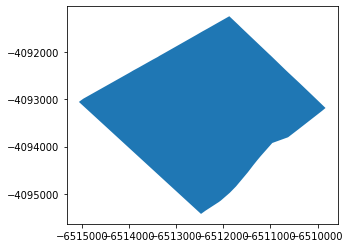

In [15]:
palermo = barrios[barrios["BARRIO"] == "MATADEROS"]
palermo.to_crs(epsg = 3395).plot() #EPSG 3395 es World Mercator. Noten los valores de los ejes, qué distintos son a 4326

### Ejercicio
1- En Google Maps buscar un punto en el barrio de Mataderos y guardar las coordenadas

2- Graficar el barrio junto al punto en EPSG 3395. Antes, piensen bien qué proyección usa Google Maps.

### Operaciones geográficas

En geopandas tenemos distintos métodos para realizar diferentes operaciones geográficas:
    - equals
    - contains
    - crosses
    - disjoint
    - overlaps
    - touches
    - within
    - covers
    - contains
    - intersects
    - intersection
    - union
    - unary_union
    - difference
    - overlay (difference, intersection, symmetric_difference) 
    - sjoin
    
    
En el siguiente link se tiene una referencia de varios de estos métodos, los heredados de shapely:
https://shapely.readthedocs.io/en/stable/manual.html#predicates-and-relationships

### Hospitales

In [ ]:
# https://data.buenosaires.gob.ar/dataset/hospitales

In [16]:
hospitales = pd.read_csv("https://datasets-humai.s3.amazonaws.com/datasets/hospitales.csv", encoding='latin1')

In [17]:
hospitales

,long,lat,id,nombre,nom_map,objeto,calle_nombre,calle_altura,calle_altura.1,dom_geo,...,mod_at_2,depend_adm,director,dom_norma,calle_altura.2,calle_altura.3,barrio,comuna,codigo_postal,codigo_postal_argentino
0,-58.377551,-34.628847,1,HOSPITAL GENERAL DE NIÃOS PEDRO DE ELIZALDE,HOSP. DE ELIZALDE,HOSPITAL,MANUEL A. MONTES DE OCA,40,MANUEL A. MONTES DE OCA 40,"40 MONTES DE OCA, MANUEL AV.",...,DIAG./TRATAM.,Ministerio de Salud GCBA,Dr. Javier Indart,"MONTES DE OCA, MANUEL AV. 40",40,MANUEL A. MONTES DE OCA 40,Barracas,Comuna 4,1270.0,C1270AAN
1,-58.412070,-34.594192,2,HOSPITAL GENERAL DE NIÃOS RICARDO GUTIERREZ,HOSP. GUTIERREZ,HOSPITAL,GALLO,1330,GALLO 1330,1330 GALLO,...,DIAG./TRATAM.,Ministerio de Salud GCBA,Dra. MarÃ­a Cristina Galoppo,GALLO 1330,1330,GALLO 1330,Recoleta,Comuna 2,1425.0,C1425EFD
2,-58.402728,-34.584528,4,HOSPITAL DE ODONTOLOGIA DR. RAMON CARRILLO (EX...,HOSP. ODONTOLOGICO CARRILLO,HOSPITAL,SANCHEZ DE BUSTAMANTE,2529,SANCHEZ DE BUSTAMANTE 2529,2529 SANCHEZ DE BUSTAMANTE,...,DIAG./TRATAM.,Ministerio de Salud GCBA,Dra. Susana Rita Lisanti,SANCHEZ DE BUSTAMANTE 2529,2529,SANCHEZ DE BUSTAMANTE 2529,Recoleta,Comuna 2,1425.0,C1425DUY
3,-58.385156,-34.639404,6,HOSPITAL DE SALUD MENTAL BRAULIO MOYANO,HOSP. MOYANO,HOSPITAL,BRANDSEN,2570,BRANDSEN 2570,2570 BRANDSEN,...,DIAG./TRATAM.,Ministerio de Salud GCBA,Dra. Norma Derito,BRANDSEN 2570,2570,BRANDSEN 2570,Barracas,Comuna 4,1287.0,C1287ABJ
4,-58.391311,-34.634154,7,HOSPITAL DE GASTROENTEROLOGIA B. UDAONDO,HOSP. UDAONDO,HOSPITAL,CASEROS,2061,CASEROS 2061,2061 CASEROS AV.,...,DIAG./TRATAM.,Ministerio de Salud GCBA,Dr. Eduardo Gustavo Sosa,CASEROS AV. 2061,2061,CASEROS 2061,Parque Patricios,Comuna 4,1264.0,C1264AAA
5,-58.434943,-34.608472,8,INSTITUTO DE ZOONOSIS L. PASTEUR,INST. PASTEUR,HOSPITAL,DIAZ VELEZ,4821,DIAZ VELEZ 4821,4821 DIAZ VELEZ AV.,...,DIAG./TRATAM.,Ministerio de Salud GCBA,Dr. Oscar Enrique Lencinas,DIAZ VELEZ AV. 4821,4821,DIAZ VELEZ 4821,Caballito,Comuna 6,1405.0,C1405DCD
6,-58.375843,-34.630211,9,HOSPITAL DE REHABILITACION RESPIRATORIA MARIA ...,HOSP. FERRER,HOSPITAL,DOCTOR ENRIQUE FINOCHIETTO,849,DOCTOR ENRIQUE FINOCHIETTO 849,849 FINOCHIETTO ENRIQUE DR.,...,DIAG./TRATAM.,Ministerio de Salud GCBA,Dra. Dora Lombardi,FINOCHIETTO ENRIQUE DR. 849,849,DOCTOR ENRIQUE FINOCHIETTO 849,Barracas,Comuna 4,1272.0,C1272AAA
7,-58.382328,-34.635702,10,HOSPITAL INFANTO JUVENIL C. TOBAR GARCIA,HOSP. TOBAR GARCIA,HOSPITAL,DOCTOR RAMON CARRILLO,315,DOCTOR RAMON CARRILLO 315,"315 CARRILLO, RAMON, DR.",...,DIAG./TRATAM.,Ministerio de Salud GCBA,Dr. Guillermo Vega,"CARRILLO, RAMON, DR. 315",315,DOCTOR RAMON CARRILLO 315,Barracas,Comuna 4,1275.0,C1275AHG
8,-58.382128,-34.636435,11,HOSPITAL DE SALUD MENTAL J. T. BORDA,HOSP. BORDA,HOSPITAL,DOCTOR RAMON CARRILLO,375,DOCTOR RAMON CARRILLO 375,"375 CARRILLO, RAMON, DR.",...,DIAG./TRATAM.,Ministerio de Salud GCBA,Dr. Daniel Cichello,"CARRILLO, RAMON, DR. 375",375,DOCTOR RAMON CARRILLO 375,Barracas,Comuna 4,1275.0,C1275AHG
9,-58.360120,-34.638892,12,HOSPITAL DE ODONTOLOGIA INFANTIL DON BENITO QU...,HOSP. ODONTOLOGICO INFANTIL QUINQUELA MARTIN,HOSPITAL,DON PEDRO DE MENDOZA,1795,DON PEDRO DE MENDOZA 1795,1795 DON PEDRO DE MENDOZA AV.,...,DIAG./TRATAM.,Ministerio de Salud GCBA,Dra. Scagnet Gabriela,DON PEDRO DE MENDOZA AV. 1795,1795,DON PEDRO DE MENDOZA 1795,Boca,Comuna 4,1169.0,C1169AAB


Nótese que en este caso la información no viene en WKT sino que contamos con una columna long y una columna lat. Vamos a ver cómo construir manualmente un punto, y luego vamos a iterar por cada fila construyendo el punto de cada hospital.

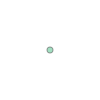

In [18]:
import numpy as np
Point((1, 1))

In [20]:
def from_x_y(df, x, y):
    gdf = geopandas.GeoDataFrame(df.drop([x, y], axis=1), # eliminamos las columnas originales
                                crs='EPSG:4326', # Agregamos CRS
                                geometry=[Point(p) for p in zip(df[x], df[y])]) # junto "x" e "y" y lo paso a Point
    return gdf

In [32]:
hospitales = from_x_y(hospitales, "long", "lat")

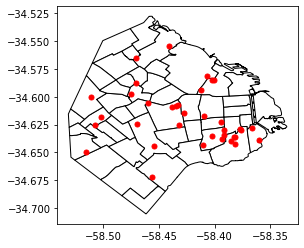

In [33]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
barrios.plot(ax=ax, color='white', edgecolor='black')
locales.plot(ax=ax, color='red', markersize=25)
plt.show();

Tomemos dos hospitales y grafiquemos una línea entre ambos puntos:

In [37]:
hospital_a = hospitales.loc[0, "geometry"]

In [38]:
hospital_b = hospitales.loc[1, "geometry"]

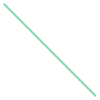

In [44]:
from shapely.geometry import LineString # Objeto línea

linea = LineString([hospital_a, hospital_b])
linea

geopandas.geoseries.GeoSeries

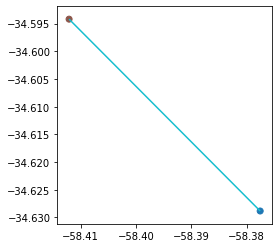

In [45]:
puntos_y_linea = geopandas.GeoSeries([hospital_a, hospital_b, linea]) # Noten que estamos guardando dos puntos y una línea
puntos_y_linea.plot(cmap='tab10'); # ploteo todo
type(puntos_y_linea)

In [52]:
barrio = barrios.loc[barrios["BARRIO"]=="BARRACAS"]

Con el método **GeoDataFrame.contains** podemos ver si un polígono contiene un punto.

In [55]:
barrio.contains(hospital_a)

29    True
dtype: bool

In [56]:
barrio.contains(hospital_b)

29    False
dtype: bool

Con el método **GeoDataFrame.crosses** podemos ver si una geometría corta otra. En este caso, para cada barrio podemos ver si se corta con la línea marcada entre los dos hospitales.

In [58]:
barrios.crosses(line)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11     True
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24     True
25    False
26    False
27    False
28    False
29     True
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41     True
42    False
43    False
44     True
45    False
46    False
47    False
dtype: bool

In [59]:
barrios[barrios.crosses(line)].BARRIO

11    CONSTITUCION
24       BALVANERA
29        BARRACAS
41       MONSERRAT
44        RECOLETA
Name: BARRIO, dtype: object

### Ejemplo. Cuarteles y destacamentos de bomberos

In [62]:
# https://data.buenosaires.gob.ar/dataset/cuarteles-destacamentos-bomberos
bomberos = pd.read_csv("https://datasets-humai.s3.amazonaws.com/datasets/bomberos.csv")
bomberos.head(3)

,id,long,lat,dcia,tipo,cuartel,gestion,calle_ofic,inters,altura,direcci,tel,barrio,comuna,codigo_postal,codigo_postal_argentino,observacion
0,1,-58.435809,-34.577526,DESTACAMENTO PALERMO,DESTACAMENTO,NaN,Policía de la Ciudad,GUATEMALA,NaN,5966,5966 GUATEMALA,4772-2222,Palermo,Comuna 14,1425,C1425BVP,NaN
1,2,-58.487654,-34.644895,DESTACAMENTO VELEZ SARSFIELD,DESTACAMENTO,NaN,Policía de la Ciudad,RODO JOSE E.,NaN,4474,4474 RODO JOSE E.,4671-2222,Parque Avellaneda,Comuna 9,1407,C1407HDR,Brigada Especial Federal De Rescate (BEFER)
2,3,-58.435415,-34.630275,DESTACAMENTO GER CABALLITO,DESTACAMENTO,NaN,Policía de la Ciudad,RIGLOS,NaN,959,959 RIGLOS,4921-2737,Parque Chacabuco,Comuna 7,1424,C1424AFS,Brigada Especial Federal De Rescate (BEFER)


In [63]:
bomberos = from_x_y(bomberos, "long","lat")

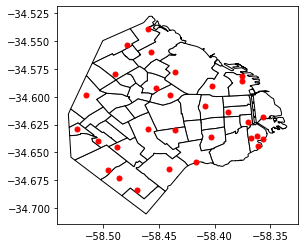

In [64]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
barrios.plot(ax=ax, color='white', edgecolor='black')
bomberos.plot(ax=ax, marker='o', color='red', markersize=25)
plt.show();

Imagínese que se desea bacer el siguiente análisis: suponiendo que cada delegación de bomberos tiene un alcance de hasta 1.5 km (ACLARACIÓN: este valor no se basa en la realidad) se desean obtener los lugares abarcados y los no abarcados por el servicio.

Para ello primero tendremos que convertir la proyección a una proyección que nos permita trabajar en metros y no en grados. Para eso usaremos la proyección  Gauss-Krueger Buenos Aires. 

Para obtener los datos de proyección se puede entrar a http://spatialreference.org/

Convertimos nuestros datasets a GKBA

In [66]:
barrios_gkba = barrios.to_crs(crs = "+proj=tmerc +lat_0=-34.629269 +lon_0=-58.4633 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs")

In [67]:
bomberos_gkba = bomberos.to_crs(crs = "+proj=tmerc +lat_0=-34.629269 +lon_0=-58.4633 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs")

Veamos cómo son los valores de la geometría ahora...

In [73]:
bomberos_gkba.head().geometry

0    POINT (102522.494 105739.771)
1      POINT (97767.105 98266.211)
2     POINT (102557.088 99887.991)
3     POINT (98539.106 108425.610)
4    POINT (106892.933 101766.659)
Name: geometry, dtype: geometry

Armamos un buffer de 1500 metros alrededor de cada cuartel y delegación de bomberos.

In [68]:
bomberos_gkba_buff = bomberos_gkba.copy()
bomberos_gkba_buff.geometry = bomberos_gkba.buffer(1500)

Vamos a plotear el área cubierta por los bomberos...

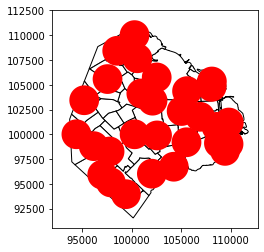

In [70]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
barrios_gkba.plot(ax=ax, color='white', edgecolor='black')
bomberos_gkba_buff.plot(ax=ax, color='red')
plt.show();

Ahora vamos a ver cómo calcular el área cubierta y el área no cubierta. El área cubierta es la **intersección** entre la capa de barrios y la capa de bomberos (con su buffer). Por otro lado, el área no cubierta es la **diferencia** entre la capa de barrios y la capa de bomberos (con su buffer).

In [74]:
intersection = geopandas.overlay(bomberos_gkba_buff, barrios_gkba, how = "intersection")

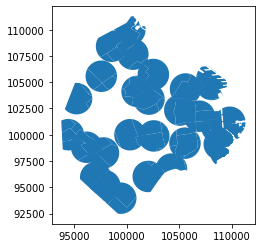

In [75]:
intersection.plot();

Los GeoDataFrame tienen un atributo con el valor del área ya calculada para cada polígono, veámoslo:

In [98]:
intersection.head().area

0    4.856944e+05
1    9.135930e+05
2    3.073288e+06
3    1.162122e+06
4    6.557971e+05
dtype: float64

Sin embargo, como podemos ver en la figura anterior, hay superposición entre los polígonos, con lo cual estaría doblecontabilizando parte del área. Para poder tener un buen cálculo del área primero debemos unir todos los polígonos en uno solo, de esa manera estaremos resolviendo la duplicación.

Para poder hacer eso vamos a tener que emplear **disolve**. Esta función junta geometrías dentro de una columna que se usa para agrupar. Por ejemplo, si quisiéramos calcular el área cubierta por barrio. Sin embargo, en nuestro caso queremos juntar todas las geometrías en una sola. Para ello usaremos un truco, construiremos una columna "constante" y la usaremos para "agrupar". Nota: es obligatorio pasar una columna de agrupamiento, si no fuera así no sería necesario este "truco".

In [91]:
intersection["const"] = 0

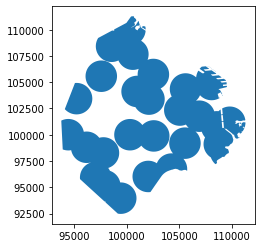

In [96]:
intersection.dissolve(by="const").plot() # los barrios agrupados

In [100]:
print("La cantidad total de metros que están cubiertos por bomberos es:", 
      round(intersection.dissolve(by="const").area.sum()))

La cantidad total de metros que están cubiertos por bomberos es: 141080651.0


Ahora calculemos el área no cubierta por el servicio, con el mismo procedimiento que antes pero empleando **difference**.

In [101]:
difference = geopandas.overlay(barrios_gkba, bomberos_gkba_buff, how = "difference")

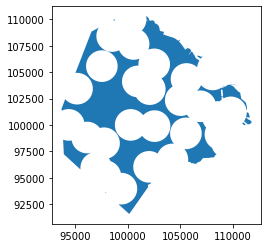

In [103]:
difference["const"] = 0
difference.dissolve(by="const").plot() # los barrios agrupados

In [105]:
print("La cantidad total de metros que no están cubiertos por bomberos es:", 
      difference.dissolve(by="const").area.sum())

La cantidad total de metros que no están cubiertos por bomberos es: 62191574.9743366


Ahora, veamos con qué precisión estamos haciendo nuestro calculo. Vamos a ver la diferencia entre las áreas computadas y el total de área en Buenos Aires.

In [108]:
difference.dissolve(by="const").area.sum() + intersection.dissolve(by="const").area.sum()

203272225.9202038

In [109]:
barrios_gkba.area.sum()

203272225.92020506

Otro uso muy común en operaciones geográficas es el cálculo de una **distancia**. Además, otro caso es el cálculo del **centroide** de un polígono.

Supongamos que se desea conocer cuáles son las 3 delegaciones de bomberos más cercanas a Palermo, para ello podemos:
    - Calcular el centroide
    - Calcula la distancia a todos los centros de bomberos
    - Quedarnos con los tres más cercanos

In [110]:
palermo = barrios_gkba[barrios_gkba["BARRIO"] == "PALERMO"].copy()
caballito = barrios_gkba[barrios_gkba["BARRIO"] == "CABALLITO"].copy()
centroid = palermo.centroid

In [112]:
caballito.centroid # vean que el centroide es un punto

5    POINT (101806.495 101380.293)
dtype: geometry

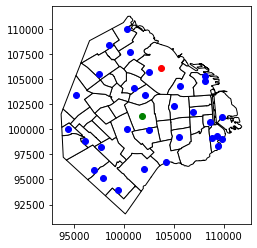

In [113]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
barrios_gkba.plot(ax=ax, color='white', edgecolor='black')
caballito.centroid.plot(ax=ax, color='green')
palermo.centroid.plot(ax=ax, color='red')
bomberos_gkba.plot(ax=ax, color='blue')
plt.show();

In [55]:
# Armamos un Point de shapely
centroid = Point(centroid.geometry.x, centroid.geometry.y)

In [56]:
type(bomberos_gkba)

geopandas.geodataframe.GeoDataFrame

In [58]:
distances = [ (i, pt.distance(centroid))  for i, pt in enumerate(bomberos_gkba.geometry)]

dist = [dist for i, dist in distances]

dist.sort()

closest = dist[0:3]

In [59]:
indexes = [i for i,j in distances if j in closest]

In [60]:
bomberos_gkba.iloc[indexes,:]

,ID,DCIA,TIPO,CUARTEL,GESTION,CALLE_OFIC,INTERS,ALTURA,DIRECC,CPA,TEL,BARRIO,COMUNA,OBSERVACION,geometry
0,1,SECCION PALERMO,DESTACAMENTO,NaN,POLICIA FEDERAL ARGENTINA,GUATEMALA,NaN,5966.0,5966 GUATEMALA,C1425BVP,4772-2222,PALERMO,COMUNA 14,NaN,POINT (102522.4944862011 105739.7710938063)
8,9,DIVISION CUARTEL IV RECOLETA,CUARTEL,IV,POLICIA FEDERAL ARGENTINA,LAPRIDA,NaN,1739.0,1739 LAPRIDA,C1425EKO,4826-9222,RECOLETA,COMUNA 2,NaN,POINT (105583.862304779 104356.7905254249)
11,12,DIVISION CUARTEL VI VILLA CRESPO,CUARTEL,VI,POLICIA FEDERAL ARGENTINA,CORRIENTES,NaN,5340.0,5340 CORRIENTES,C1414AJT,4854-2222,VILLA CRESPO,COMUNA 15,NaN,POINT (102101.6356713405 103393.2613214973)


## Visualización

Existen distintos paquetes para visualizar mapas entre las que se listan:
- Bokeh: https://bokeh.pydata.org/en/latest/docs/gallery/texas.html
- GeoViews (other interface to Bokeh/matplotlib): http://geo.holoviews.org
- Altair: https://altair-viz.github.io/gallery/choropleth.html
- Plotly: https://plot.ly/python/#maps


In [61]:
import folium

In [62]:
m = folium.Map([-34.606359, -58.443863], zoom_start=12, tiles="OpenStreetMap")
folium.GeoJson(barrios.to_json()).add_to(m)
folium.GeoJson(bomberos.to_json()).add_to(m)
m